# Sizing Experimentation and Testing

This notebook will be used to test the sizing agent to ensure that the results are suitable. 

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Sizing Agent Class

In [2]:
import cv2
import numpy as np

class SizingAgent:
    def __init__(self, pixel_to_mm_ratio=None):
        self.pixel_to_mm_ratio = pixel_to_mm_ratio or 0.39
    
    def load_image(self, image_path):
        if isinstance(image_path, str):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            return image
        return ValueError("Image path must have a suitable image.")

    def create_mask(self, image):
        # Convert to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 50, 50])
        upper_red2 = np.array([180, 255, 255])

        # Combine masks for lower and upper red hues
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)

        return red_mask

    def extract_aneurysm(self, mask):
        _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest = max(contours, key=cv2.contourArea)

        bounding_boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
        return cv2.boundingRect(largest), largest, bounding_boxes

    def measure(self, mask):
        (_, _, w, h), contour, bboxes = self.extract_aneurysm(mask)

        length_px = max(w, h)
        width_px = min(w, h)
        area_px2 = cv2.contourArea(contour)

        return {
            "length_mm": round(length_px * self.pixel_to_mm_ratio, 2),
            "width_mm": round(width_px * self.pixel_to_mm_ratio, 2),
            "area_mm2": round(area_px2 * (self.pixel_to_mm_ratio ** 2), 2),
            "pixel_to_mm_ratio": self.pixel_to_mm_ratio
        }


### Data processing
Load the image.

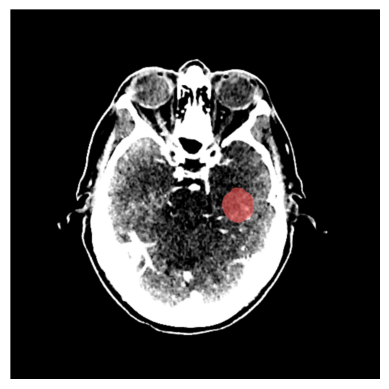

In [7]:
ratio = 0.30
agent = SizingAgent(pixel_to_mm_ratio=ratio)

# Insert the image path here:
image_path = "../../../data/images/segmentation_output.png"
image = SizingAgent.load_image(agent, image_path=image_path)

# Display the image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


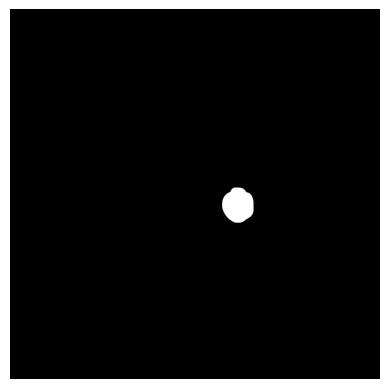

In [8]:

aneurysm_mask = SizingAgent.create_mask(agent, image=image)

# Display the mask
plt.imshow(aneurysm_mask, cmap='gray')
plt.axis('off')
plt.show()

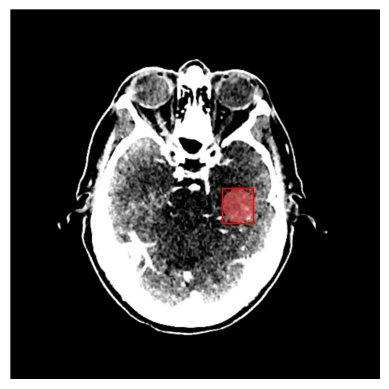

In [9]:
box, contour, bounding_boxes = agent.extract_aneurysm(mask=aneurysm_mask)
x, y, w, h = box

# Display the bounds
plt.imshow(image_rgb)
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))
plt.show()


In [10]:
size_information = agent.measure(aneurysm_mask)

print("Size Information:")
for key, value in size_information.items():
    print(f"{key}: {value:.2f} mm")

"""
NOT REAL INFORMATION, JUST A TEST
"""



Size Information:
length_mm: 58.50 mm
width_mm: 52.20 mm
area_mm2: 2343.91 mm
pixel_to_mm_ratio: 0.30 mm


'\nNOT REAL INFORMATION, JUST A TEST\n'